# I FORGOT to Remove PID from the first model. NEED TO REMOVE and re model

## Load Packages and Data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from tqdm import tqdm


# this extension properly formats a cell after it is run
# !{sys.executable} -m pip install nb_black # UNCOMMENT TO INSTALL
%load_ext nb_black
%matplotlib inline

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)

# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

<IPython.core.display.Javascript object>

In [50]:
# Load Data
housing_raw = pd.read_csv("../data/Ames_Housing_Price_Data.csv")

housing_clean = pd.read_csv("../data/housing_cleaned.csv")  # All features included

housing_corr = pd.read_csv(
    "../data/housing_corr.csv"
)  # 13 features removed because of colinearity

<IPython.core.display.Javascript object>

In [51]:
housing_raw.shape

(2580, 82)

<IPython.core.display.Javascript object>

In [53]:
housing_clean.shape

(2559, 83)

<IPython.core.display.Javascript object>

In [52]:
housing_corr.shape

(2558, 71)

<IPython.core.display.Javascript object>

In [67]:
# Features Removed for Correlation Issues
set1 = set(housing_raw.columns)
set2 = set(housing_clean.columns)
set3 = set(housing_corr.columns)

print(
    "Removed ",
    len(set2.difference(set3)),
    " colinear features: \n\n",
    set2.difference(set3),
)

Removed  13  colinear features: 

 {'FireplaceQu', '1stFlrSF', 'GarageCars', 'GarageCond', 'YearBuilt', 'GarageYrBlt', 'FullBath', 'YearRemodAdd', 'GrLivArea', 'BsmtFinType2', 'BsmtFinType1', 'ExterQual', 'TotalBsmtSF'}


<IPython.core.display.Javascript object>

#### Small Pre-Processing

In [70]:
# Removing PID column, as it is a unique identifier per row
housing_corr = housing_corr.drop("PID", axis=1)
housing_clean = housing_clean.drop("PID", axis=1)

<IPython.core.display.Javascript object>

## Label Encoding for Categorical Values

In [5]:
# In order to do regression, I need to turn categorical values into numerical values
housing_corr.dtypes

SalePrice            int64
MSSubClass           int64
MSZoning            object
LotFrontage        float64
LotArea              int64
Street              object
Alley               object
LotShape            object
LandContour         object
Utilities           object
LotConfig           object
LandSlope           object
Neighborhood        object
Condition1          object
Condition2          object
BldgType            object
HouseStyle          object
OverallQual          int64
OverallCond          int64
RoofStyle           object
RoofMatl            object
Exterior1st         object
Exterior2nd         object
MasVnrType          object
MasVnrArea         float64
ExterCond            int64
Foundation          object
BsmtQual             int64
BsmtCond             int64
BsmtExposure         int64
BsmtFinSF1         float64
BsmtFinSF2         float64
BsmtUnfSF          float64
Heating             object
HeatingQC            int64
CentralAir          object
Electrical          object
2

<IPython.core.display.Javascript object>

In [74]:
# List categorical columns to be label encoded for train/test
cat_cols = housing_corr.select_dtypes(include=["object"]).columns.tolist()
cat_cols2 = housing_clean.select_dtypes(include=["object"]).columns.tolist()

# Create a dictionary to store the label encoded values
cat_cols_encoded = {}

# Label Encode the categorical columns in both train/test set to values 1,2,3,4 etc.
le = LabelEncoder()
for column in cat_cols:
    housing_corr[column + "_encoded"] = le.fit_transform(housing_corr[column])
    # Store the mapping of original column to encoded column in the dictionary
    cat_cols_encoded[column] = column + "_encoded"

# Deleting all Object type columns, now that they've been replaced with labelencoded values
housing_corr_drop = housing_corr.select_dtypes(include="object").columns
housing_corr = housing_corr.drop(housing_corr_drop, axis=1)

# Create a dictionary to store the label encoded values
cat_cols_encoded2 = {}

# Label Encode the categorical columns in both train/test set to values 1,2,3,4 etc.
le2 = LabelEncoder()
for column in cat_cols2:
    housing_clean[column + "_encoded"] = le.fit_transform(housing_clean[column])
    # Store the mapping of original column to encoded column in the dictionary
    cat_cols_encoded[column] = column + "_encoded"

# Deleting all Object type columns, now that they've been replaced with labelencoded values
housing_corr_drop = housing_clean.select_dtypes(include="object").columns
housing_clean = housing_clean.drop(housing_corr_drop, axis=1)


<IPython.core.display.Javascript object>

In [75]:
# Did it work? yes!
print(housing_corr.shape, housing_corr.dtypes)
print(housing_clean.shape, housing_clean.dtypes)

(2559, 82) GrLivArea                   int64
SalePrice                   int64
MSSubClass                  int64
LotFrontage               float64
LotArea                     int64
OverallQual                 int64
OverallCond                 int64
YearBuilt                   int64
YearRemodAdd                int64
MasVnrArea                float64
BsmtFinSF1                float64
BsmtFinSF2                float64
BsmtUnfSF                 float64
TotalBsmtSF               float64
1stFlrSF                    int64
2ndFlrSF                    int64
BsmtFullBath              float64
BsmtHalfBath              float64
FullBath                    int64
HalfBath                    int64
BedroomAbvGr                int64
KitchenAbvGr                int64
TotRmsAbvGrd                int64
Fireplaces                  int64
GarageYrBlt               float64
GarageCars                float64
GarageArea                float64
WoodDeckSF                  int64
OpenPorchSF                 int64
Enc

<IPython.core.display.Javascript object>

In [76]:
# Triple Check that there are no object values
strings = housing_corr.select_dtypes(include=["object"]).columns
print(strings)

Index([], dtype='object')


<IPython.core.display.Javascript object>

## Train Test Split

In [96]:
# All Columns
X0 = housing_clean.loc[:, housing_corr.columns != "SalePrice"]
y0 = housing_clean.loc[:, "SalePrice"]
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0,
    y0,
    random_state=42,
    test_size=0.3,  # stratify=housing_corr["Neighborhood"] # commenting out for now
)

# Columns Removed
X = housing_corr.loc[:, housing_corr.columns != "SalePrice"]
y = housing_corr.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.3,  # stratify=housing_corr["Neighborhood"] # commenting out for now
)

<IPython.core.display.Javascript object>

In [10]:
print(X_train.shape)
print(X_test.shape)

(1790, 69)
(768, 69)


<IPython.core.display.Javascript object>

## Define Model 

In [11]:
# Define Model and Variables
initial_model = GradientBoostingRegressor()

<IPython.core.display.Javascript object>

## Checking to see if any columns are just 0's

In [12]:
all_zero_cols_train = []
for col in X_train.columns:
    if (X_train[col] == 0).all():
        all_zero_cols_train.append(col)
print(all_zero_cols_train)

all_zero_cols_test = []
for col in X_test.columns:
    if (X_test[col] == 0).all():
        all_zero_cols_test.append(col)
print(all_zero_cols_test)

['Utilities_encoded']
[]


<IPython.core.display.Javascript object>

## Gradient Boosting Regression Model

#### All Features Model

In [98]:
initial_model0 = GradientBoostingRegressor()
initial_model.fit(X0_train, y0_train)
r2mae_scores(initial_model0, X0_test, y0_test)

      Iter       Train Loss   Remaining Time 
         1  4246297217.9386            1.15s
         2  3646727863.3591            1.05s
         3  3138742267.3508            1.00s
         4  2725157697.1546            0.96s
         5  2378299516.0712            0.95s
         6  2080741111.5603            0.93s
         7  1836120932.0663            0.89s
         8  1629885005.1010            0.86s
         9  1459589275.8212            0.83s
        10  1308456424.2599            0.80s
        20   598065214.1904            0.62s
        30   382896177.5773            0.52s
        40   288563245.3312            0.44s
        50   240034182.1090            0.36s
        60   210217125.0462            0.29s
        70   188749475.4267            0.21s
        80   173822673.5389            0.14s
        90   164549303.3256            0.07s
       100   155553044.7940            0.00s
--------------------------------------------------
R^2 scores: [0.9089592  0.80531907 0.91108663 0.

<IPython.core.display.Javascript object>

#### 13 Features Removed Model

In [81]:
# Fit Model
initial_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1  4534454921.8870            0.92s
         2  3888989768.9006            0.86s
         3  3358108692.8907            0.82s
         4  2910298982.8630            0.75s
         5  2532700085.7072            0.74s
         6  2221492711.0689            0.74s
         7  1959959146.7723            0.73s
         8  1739991416.5336            0.71s
         9  1552496543.3115            0.69s
        10  1394570132.2613            0.67s
        20   621502546.7826            0.52s
        30   394462538.6702            0.43s
        40   295676067.7593            0.36s
        50   248108290.9238            0.30s
        60   217429980.0547            0.24s
        70   196515561.3329            0.17s
        80   181139525.3714            0.12s
        90   169731012.6881            0.06s
       100   160277304.6990            0.00s


GradientBoostingRegressor(verbose=1)

<IPython.core.display.Javascript object>

## Evaluate the base model

In [77]:
# Creating a scoring function

def r2mae_scores(model, X, y):
    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(
        model, X, y, 
        cv=5, 
        scoring="r2",
        n_jobs=-1
    )

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, 
        cv=5, 
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores
    
    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    # Print the scores

    print('-'*50)
    print("R^2 scores:", r2_scores)
    print("MAE scores:", mae_scores)
    print('-'*50)
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print('-'*50)
    
# Run Function
r2mae_scores(initial_model, X_train, y_train)
    


--------------------------------------------------
R^2 scores: [0.87932817 0.93584637 0.93815728 0.93437865 0.92347707]
MAE scores: [14800.4816255  13851.74775871 13107.43809284 11328.54531108
 12835.44775822]
--------------------------------------------------
Average R^2 score: 0.9222375073194404
Average MAE score: 13184.732109270542
--------------------------------------------------


<IPython.core.display.Javascript object>

Note that we pass the negative of the MAE scores because scikit-learn's cross_val_score() function expects a scoring function that returns higher values for better performance, but MAE returns lower values for better performance. We then convert the negative scores back to positive by multiplying them with -1 and print the array of scores and the average score using the np.mean() function.

## Tuning the Hyper Parameters

In [15]:
## GridSearchCV - Creates Tuned Model

param_grid = {
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
}

tuned_model_GSV = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,  # use all available CPU cores
    verbose=1,
)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_absolute_error', verbose=1)

<IPython.core.display.Javascript object>

In [16]:
print("Best hyperparameters: ", tuned_model_GSV.best_params_)

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


<IPython.core.display.Javascript object>

In [17]:
tuned_model_GSV.cv_results_

{'mean_fit_time': array([ 0.49210091,  2.53585138,  5.11918292,  0.8421865 ,  4.21500177,
         8.47200041,  1.19131413,  5.93269477, 11.95309825,  0.51724777,
         2.57364559,  5.17411647,  0.85534539,  4.22990623,  8.50466957,
         1.18852878,  5.95529113, 11.91915202,  0.51966238,  2.57178478,
         5.15499873,  0.85087662,  4.24530582,  8.52523127,  1.20235496,
         5.70577359,  7.31320291]),
 'std_fit_time': array([0.0210714 , 0.0166117 , 0.02318666, 0.00308862, 0.02107358,
        0.05181518, 0.00515951, 0.02343067, 0.09439152, 0.00423947,
        0.01146634, 0.02901595, 0.0082998 , 0.01622392, 0.05751113,
        0.00521845, 0.02719073, 0.09629628, 0.0033352 , 0.01083372,
        0.02731423, 0.00306178, 0.02269129, 0.06504502, 0.00950552,
        0.05973331, 1.63979901]),
 'mean_score_time': array([0.00191507, 0.00401349, 0.00589347, 0.00237126, 0.00718102,
        0.01073179, 0.00292134, 0.00996447, 0.01601667, 0.00229058,
        0.00380182, 0.00640655, 0.002

<IPython.core.display.Javascript object>

## Vizualizing Tuned Parameters

#### n_estimators vs. max_depth
Each cell of the heatmap represents the mean test score obtained by the model when it was trained. The color of each cell indicates the magnitude of the mean test score, where red represents higher mean test scores and blue represents lower mean test scores. A higher test score is better; so the combination of hyperparameters `max_depth=5` and `n_estimators=1000` is the optimize selection.

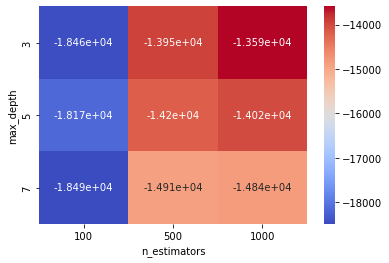

<IPython.core.display.Javascript object>

In [18]:
results = pd.DataFrame(tuned_model_GSV.cv_results_)
table = pd.pivot_table(
    results,
    values="mean_test_score",
    index="param_max_depth",
    columns="param_n_estimators",
)
sns.heatmap(
    table,
    annot=True,
    fmt=".4g",
    cmap="coolwarm",
    cbar_kws={"format": ticker.ScalarFormatter(useMathText=False)},
)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

#### learning_rate vs Mean Test Score
This shows that .1 is the best learning rate because it balances effeciency and effectiveness, right in the elbow. 

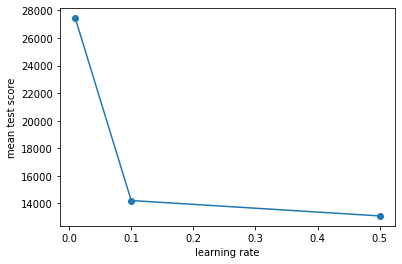

<IPython.core.display.Javascript object>

In [19]:
learning_rates = [0.01, 0.1, 0.5]
scores = [
    -tuned_model_GSV.cv_results_["mean_test_score"][i] for i in range(len(learning_rates))
]

plt.plot(learning_rates, scores, "-o")
plt.xlabel("learning rate")
plt.ylabel("mean test score")
plt.show()

## Evaluate the tuned model on TRAIN data

In [78]:
tuned_model = GradientBoostingRegressor(
    learning_rate=0.1, max_depth=3, n_estimators=500
)

tuned_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=500)

<IPython.core.display.Javascript object>

In [82]:
# Evaluate TUNED model
r2mae_scores(tuned_model, X_train, y_train)

--------------------------------------------------
R^2 scores: [0.88221024 0.94038402 0.94561436 0.93969732 0.93329156]
MAE scores: [14091.08530567 12903.70705369 12470.44852614 10991.66956658
 12562.14713382]
--------------------------------------------------
Average R^2 score: 0.9282395005674079
Average MAE score: 12603.811517176675
--------------------------------------------------


<IPython.core.display.Javascript object>

In [83]:
# Compare to initial model
r2mae_scores(initial_model, X_train, y_train)

--------------------------------------------------
R^2 scores: [0.88114946 0.93633068 0.93892581 0.93555848 0.92536664]
MAE scores: [14797.01254309 13825.10082889 13143.06626613 11406.72149133
 12755.12263974]
--------------------------------------------------
Average R^2 score: 0.9234662141645422
Average MAE score: 13185.404753834102
--------------------------------------------------


<IPython.core.display.Javascript object>

## Evaluate the Tuned Model on TEST data

In [84]:
# Evaluate the model on the test data
r2mae_scores(tuned_model, X_test, y_test)

--------------------------------------------------
R^2 scores: [0.90127352 0.91579189 0.93375183 0.90651711 0.79376479]
MAE scores: [15757.53117324 15411.52872349 14547.9278185  13613.90830177
 18192.58498171]
--------------------------------------------------
Average R^2 score: 0.8902198267255266
Average MAE score: 15504.696199742175
--------------------------------------------------


<IPython.core.display.Javascript object>

In [85]:
r2mae_scores(initial_model, X_test, y_test)

--------------------------------------------------
R^2 scores: [0.89579894 0.91272847 0.92534416 0.90169735 0.79434711]
MAE scores: [16419.00230026 15782.12406531 15629.70168218 14054.22392243
 18001.68306754]
--------------------------------------------------
Average R^2 score: 0.8859832054706415
Average MAE score: 15977.34700754297
--------------------------------------------------


<IPython.core.display.Javascript object>

## Feature Importance

In [86]:
sorted_importance = sorted(
    zip(X_train.columns, tuned_model.feature_importances_),
    key=lambda t: t[1],
    reverse=True,
)
sorted_importance

[('TotalSF', 0.3767484697409862),
 ('OverallQual', 0.36807375045090246),
 ('Age', 0.03708951310083222),
 ('TotalBath', 0.03134182424094119),
 ('KitchenQual', 0.029116305913770246),
 ('GarageArea', 0.02179092268019926),
 ('BsmtFinSF1', 0.016666128457316395),
 ('LotArea', 0.015710953176372756),
 ('Fireplaces', 0.013626453429201291),
 ('OverallCond', 0.011577428917092951),
 ('RemodAge', 0.011349371725977464),
 ('2ndFlrSF', 0.010827689782668041),
 ('MasVnrArea', 0.008038346025015158),
 ('Neighborhood_st_encoded', 0.005862407005680674),
 ('BsmtQual', 0.004673710910746851),
 ('CentralAir_encoded', 0.003584522172768761),
 ('GarageType_encoded', 0.0030641089973760757),
 ('TotRmsAbvGrd', 0.002844682451575496),
 ('BsmtUnfSF', 0.0024435393858524682),
 ('MSZoning_encoded', 0.002293495958856392),
 ('WoodDeckSF', 0.0018231004386469283),
 ('BsmtExposure', 0.0018095822540614038),
 ('SaleCondition_encoded', 0.0017345057156897233),
 ('HeatingQC', 0.0012249091994310322),
 ('TotalPorchSF', 0.0011502702354

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Feature Importance Plot of Tuned 500-Tree GBM')

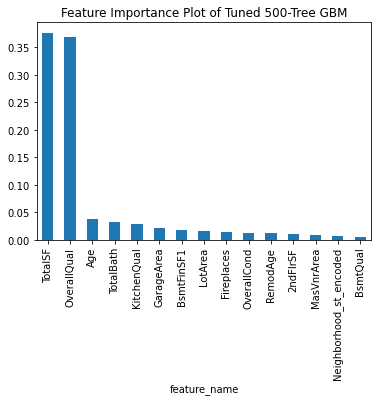

<IPython.core.display.Javascript object>

      Iter       Train Loss   Remaining Time 
         1  4393896908.5902            0.53s
         2  3756551921.6584            0.51s
         3  3217213476.1245            0.49s
         4  2779450071.1063            0.47s
         5  2413287742.5092            0.46s
         6  2108831628.9335            0.45s
         7  1844608961.2331            0.44s
         8  1628973781.6834            0.43s
         9  1444507668.9017            0.43s
        10  1286953265.2377            0.42s
        20   568551922.7809            0.37s
        30   363399319.1903            0.32s
        40   278498613.8782            0.27s
        50   234911421.1381            0.23s
        60   207925098.8809            0.18s
        70   187719843.7274            0.14s
        80   172530467.1315            0.09s
        90   162432769.9741            0.05s
       100   153872315.5009            0.00s
      Iter       Train Loss   Remaining Time 
         1  4465257196.0708            0.50s
        

In [87]:
a, b = zip(*sorted_importance[:15])
pd.DataFrame({"feature_name": a, "importance_score": b}).plot.bar(
    x="feature_name", y="importance_score", legend=None
)
plt.title("Feature Importance Plot of Tuned 500-Tree GBM")

## Feature Selection MODEL

In [89]:
## isolate top 5 features to see if any improvement on scores
X2_train = X_train[["TotalSF", "OverallQual", "Age", "TotalBath", "KitchenQual"]]
y2_train = y_train.copy()
X2_test = X_test[["TotalSF", "OverallQual", "Age", "TotalBath", "KitchenQual"]]
y2_test = y_test.copy()

<IPython.core.display.Javascript object>

In [95]:
select_model5 = GradientBoostingRegressor()
select_model5.fit(X2_train, y2_train)
r2mae_scores(select_model5, X2_test, y2_test)

--------------------------------------------------
R^2 scores: [0.86567863 0.87777512 0.88970443 0.92308009 0.76908894]
MAE scores: [18536.55608557 19036.45886011 19263.84742288 15602.26463008
 22176.20944733]
--------------------------------------------------
Average R^2 score: 0.8650654418673117
Average MAE score: 18923.067289195416
--------------------------------------------------


<IPython.core.display.Javascript object>

Selecting the top 5 features, actually performed worse, maybe top 10 will work better?

In [94]:
X3_train = X_train[
    [
        "TotalSF",
        "OverallQual",
        "Age",
        "TotalBath",
        "KitchenQual",
        "GarageArea",
        "BsmtFinSF1",
        "LotArea",
        "Fireplaces",
        "OverallCond",
    ]
]
y3_train = y_train.copy()
X3_test = X_test[
    [
        "TotalSF",
        "OverallQual",
        "Age",
        "TotalBath",
        "KitchenQual",
        "GarageArea",
        "BsmtFinSF1",
        "LotArea",
        "Fireplaces",
        "OverallCond",
    ]
]
y3_test = y_test.copy()

select_model10 = GradientBoostingRegressor()
select_model10.fit(X3_train, y3_train)
r2mae_scores(select_model10, X3_test, y3_test)

--------------------------------------------------
R^2 scores: [0.88532307 0.90584142 0.91840961 0.90223075 0.75439248]
MAE scores: [16885.91553091 15849.01313859 15512.138059   14541.876098
 20380.87253236]
--------------------------------------------------
Average R^2 score: 0.8732394659611309
Average MAE score: 16633.96307177403
--------------------------------------------------


<IPython.core.display.Javascript object>

## Feature Engineering: Street Grouping
#### Function from Creating_test_train notbook with a few changes

In [ ]:
# Adding Neighborhood street back to df
streets = housing_corr[["PID", "Neighborhood_st", "SalePrice"]]

train_dummies_w_streets = pd.merge(train_dummies, streets, how="left", on="PID")
test_dummies_w_streets = pd.merge(test_dummies, streets, how="left", on="PID")

In [ ]:
## Group Streets by Sale Price ##

# creating a function to create groups based on mean sale price of streets in each
# neighborhood of the training df and adds a new column with the groups created
# It then uses the groups created using the training dataframe and creates a new column
# in the testing dataframe by mapping these groups.  This will result in missing values
# If there is a street neighborhood combination that was in the training dataset but 
# not the testing dataset


def group_neighbor_streets_by_saleprice(
    traindf=train_dummies_w_streets, testdf=test_dummies_w_streets, num_quantiles=10  # notice the difference in this line!!
):
    # Calculate the mean sale price for each street in the training df
    street_prices = traindf.groupby("Neighborhood_st")["SalePrice"].mean()
    
    # Group the streets into the specified number of quantiles based on sale price
    labels = [f"group_{i+1}" for i in range(num_quantiles)]
    groups = pd.qcut(street_prices, q=num_quantiles, labels=range(1, num_quantiles + 1))
    
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = dict(zip(street_prices.index, groups))
    
    # Add a new column to the training dataframe with the street price groups
    traindf["StreetPriceGroup"] = traindf["Neighborhood_st"].map(street_group_dict)
    
    # Add a new column to the testing dataframe with the street price groups
    testdf["StreetPriceGroup"] = testdf["Neighborhood_st"].map(street_group_dict)
    return street_group_dict


In [ ]:
# the num of quantiles can be changed and it is assigned to d which is the dictionary that
# will be used to fill in the missing values

d = group_neighbor_streets_by_saleprice(
    traindf=train_dummies_w_streets,  # the difference here as well!!
    testdf=test_dummies_w_streets,  # the difference here as well!!
    num_quantiles=10,
)

In [ ]:
## Supporting Function to group_neighbor_streets_by_saleprice to FILL_NA's ##

# Dictionary stores missing values in the test df with another group in the same neighborhood


def fill_na(testdf=test_dummies_w_streets, d={}):  # DIFFERENT HERE TOO
    # Extract the first part of the string in the "Neighborhood_st" column
    testdf["Neighborhood_prefix"] = testdf["Neighborhood_st"].map(
        lambda x: x.split("_")[0]
    )

    # Create a new dict that only contains the neighborhood
    new_dict = {k.split("_")[0]: v for k, v in d.items()}

    # Create a list of PIDs with missing StreetPriceGroup values
    na_pid_list = testdf[testdf["StreetPriceGroup"].isna()]["PID"].tolist()

    # Create a Boolean mask to filter the DataFrame
    mask = testdf["PID"].isin(na_pid_list)

    # Apply the dictionary mapping only to the filtered rows
    testdf.loc[mask, "StreetPriceGroup"] = testdf[mask]["Neighborhood_prefix"].map(
        new_dict
    )

    # Drop the column since there is no more use for it
    testdf.drop("Neighborhood_prefix", axis=1, inplace=True)

In [ ]:
fill_na(test_dummies_w_streets, d)

In [ ]:
# Remove the column that was used to create groupings
train_dummies_w_streets.drop("Neighborhood_st", axis=1, inplace=True)
test_dummies_w_streets.drop("Neighborhood_st", axis=1, inplace=True)

In [ ]:
# Looks like PID should be removed and SalePrice moved to the first column
train_dummies_w_streets

In [ ]:
# Remove PID and move SalePrice to first column
# I need to do this in the future and save the csv's after so we dont have to do this each time

# TRAIN
train_dummies_w_streets = train_dummies_w_streets.iloc[
    :,
    train_dummies_w_streets.columns.tolist().index("SalePrice") : (
        train_dummies_w_streets.columns.tolist().index("SalePrice") + 1
    ),
].join(train_dummies_w_streets.drop(columns=["SalePrice", "PID"]))

# TEST
test_dummies_w_streets = test_dummies_w_streets.iloc[
    :,
    test_dummies_w_streets.columns.tolist().index("SalePrice") : (
        test_dummies_w_streets.columns.tolist().index("SalePrice") + 1
    ),
].join(test_dummies_w_streets.drop(columns=["SalePrice", "PID"]))

In [ ]:
# One Hot Encode it.

# List categorical columns to be dummified for train/test
cat_cols = ["StreetPriceGroup"]

# Dummify the categorical columns in both train/test set
train_dummies_w_streets2 = pd.get_dummies(train_dummies_w_streets, columns=cat_cols)
test_dummies_w_streets2 = pd.get_dummies(test_dummies_w_streets, columns=cat_cols)

# Ensure the same dummy columns are present in both train and test sets
train_dummies_w_streets2, test_dummies_w_streets2 = train_dummies_w_streets2.align(
    test_dummies_w_streets2, join="left", axis=1
)

# Fill any missing columns in the test set with zeros
test_dummies_w_streets2.fillna(0, inplace=True)

## Same processing as before

In [ ]:
# Define Model and Variables
initial_model2 = GradientBoostingRegressor()
X_train2 = train_dummies_w_streets2
y_train2 = y_train.copy()
X_test2 = test_dummies_w_streets2
y_test2 = y_test.copy()

# Drop columns with less than 20 observations in it's column
col_sums2 = X_train2.iloc[:, 45:].sum()
col_sums_filt2 = col_sums2[col_sums2 < 20]

small_dumb_cols2 = list(col_sums_filt2.index)

X_train2.drop(columns=small_dumb_cols2, inplace=True)
X_test2.drop(columns=small_dumb_cols2, inplace=True)

## Model

In [ ]:
# initial_model.set_params(verbose=1)
# initial_model.fit(X_train, y_train)
# initial_scores = cross_val_score(
#     initial_model, X_train, y_train, 
#     cv=5, 
#     scoring="neg_mean_squared_error", 
#     verbose=2
# )
# print("Initial Model RMSE: ", np.sqrt(-1 * np.mean(initial_scores)))

## YE OLD CODE DUMP

In [ ]:
# k-fold cross-validation

# Create the Gradient Boosted Regression model and evaluate it using k-fold cross-validation
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_scores.append(mse)
    r2_scores.append(r2)

print("MSE scores:", mse_scores)
print("R-squared scores:", r2_scores)

The output shows the MSE and R-squared scores for each fold of the cross-validation. 
The MSE scores range from 322,746,634 to 949,124,370 while the R-squared scores range from 0.8501 to 0.9400. 

These scores indicate how well the model is performing on the testing data, with higher R-squared scores and lower MSE scores indicating better performance. 

The fact that the R-squared scores are relatively high and the MSE scores are relatively low suggests that the model is performing well on the data.

## Tuning

In [ ]:
def tune_gbm(learning_rate, max_depth):
    gbm = GradientBoostingRegressor(
        learning_rate=learning_rate, n_estimators=10000, max_depth=max_depth
    )
    gbm.fit(X_train, y_train)

    return gbm

def demo_gbm_tuning(model, start=0, end=10000, training_curve=True):
    """
    This function takes a GBM regression model model as input and generates a 
    performance visualization of the model using the test dataset (X_test and y_test). 
    The function calculates the mean squared error (MSE) on both the training and test 
    datasets using a generator that iteratively predicts the targets for different numbers of estimators. 
    The start and end arguments control the range of the x-axis (i.e., the number of estimators), 
    and the training_curve argument controls whether to show the training curve or not. 
    The function also prints the best test score and the corresponding number of estimators.
    """
    gen_train = model.staged_predict(X_train)
    gen_test = model.staged_predict(X_test)

    trainMSE = []
    testMSE = []
    steps = range(1, 10001)
    for n in tqdm(steps):
        y_pred_train = next(gen_train)
        y_pred_test = next(gen_test)
        trainMSE.append(mean_squared_error(y_pred_train, y_train))
        testMSE.append(mean_squared_error(y_pred_test, y_test))

    print(
        "The best test score is {:.2f} at the step {}".format(
            min(testMSE), np.argmin(testMSE) + 1
        )
    )
    print("-" * 50)
    plt.plot(range(start, end), testMSE[start:end], label="test")
    if training_curve:
        plt.plot(range(start, end), trainMSE[start:end], label="train")
    plt.legend()
    plt.show()


In [ ]:
learning_rate = 0.001
max_depth = 4

model1 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000  # change start and end to zoom in

demo_gbm_tuning(model1, start, end)

The goal is to find the optimal number of estimators where the blue line is at its lowest point while the orange line is also decreasing or leveling off. This will ensure that the model is not overfitting and is generalizing well to new data.

The curve with the lowest test MSE represents the best-performing learning rate.

You can also look at the shape of the curves to gain insight into the behavior of the model. If the curves are flat or increasing, it may indicate that the model is overfitting or underfitting the data. If the curves are decreasing and plateauing, it may suggest that the model is performing well and additional tuning may not be necessary.

In [ ]:
learning_rate = 0.05
max_depth = 4

model2 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000

demo_gbm_tuning(model2, start, end)

In [ ]:
learning_rate = 0.01
max_depth = 4

model2 = tune_gbm(learning_rate, max_depth)

start = 0
end = 10000

demo_gbm_tuning(model2, start, end)

In [ ]:
top_n = 20

sorted_importance = sorted(
    zip(X_train.columns, gbm.feature_importances_), key=lambda t: t[1], reverse=True,
)[:top_n]

sorted_importance

In [ ]:
a, b = zip(*sorted_importance)  # this splits the list of tuples into two lists
pd.DataFrame({"feature_name": a, "importance_score": b}).plot.bar(
    x="feature_name", y="importance_score", legend=None
)
plt.title("Feature Importance Plot")

In [ ]:
## Cumulative Feature Importance ##


cumulative_importance = np.cumsum([x[1] for x in sorted_importance])

plt.plot(cumulative_importance)
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Feature Importance")
plt.show()

In [ ]:
## WARNING ## 
## This takes 20+min to run ##

# Grid Search for best parameters

# Define the parameter grid to search
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [5000, 10000, 20000]
}

# Create a GBM model
gbm = GradientBoostingRegressor(max_depth=4)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gbm, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)


In [ ]:
-------------------

In [ ]:
# DROPPED 2023-03-27

# None of the columns have all o's
# BUT some of the dummified columns have a very small amount of data

col_sums = X_train.iloc[:, 45:].sum()
col_sums_filt = col_sums[col_sums < 20]
print(col_sums_filt.sort_values())

# Remove all the dummified columns that were only 20 or less observations.
# out of the total 1790 observations of the train set

small_dumb_cols = list(col_sums_filt.index)

X_train.drop(columns=small_dumb_cols, inplace=True)
X_test.drop(columns=small_dumb_cols, inplace=True)

# Dropped ~78 columns
print(X_train.shape)
print(X_test.shape)